# Merger models of blue supergiants 

Hertzsprung-Russell diagram

by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Yale University, USA_ \
$^3$_Stellar Astrophysics Centre, Aarhus, Denmark_

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from ipywidgets import interact, IntSlider

import seaborn as sns

In [2]:
# Set plotting style 
sns.set(style="ticks", palette="muted", 
        rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('thinfig')
%config InlineBackend.figure_format = "retina"

In [3]:
import importlib
#import star
#importlib.reload(star)
#from star import *
from mesagrid import Track, Grid

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L']
cpus = 8

In [6]:
def load_history_extras(self, DF_):
    v_hr = np.sqrt(np.diff(DF_['log_L'])**2 + np.diff(DF_['log_Teff'])**2) / np.diff(DF_['star_age'])
    DF_['v_hr'] = np.concatenate(([np.nan], v_hr))
    return DF_

In [7]:
grid_dirs = ["work/grid_normal", "work/grid_merge", "work/grid_semi"]
grid_normal, grid_merger, grid_semi = [
    Grid(dir, load_history_extras=load_history_extras,
                                #usecols_profiles=usecols_profiles,
                                usecols_history=usecols_history,
                                cpus=cpus)
                            for dir in grid_dirs]

In [8]:
grid = grid_normal.filter({'os': 0.335, 'Z': 0.02})
c = np.nanmin(grid.loc[grid['M'].idxmin()]['Track'].history.v_hr)
c

100%|████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 102413.64it/s]

Parsing {'M': 10.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481fdf0>}


7.496537805710548e-09

In [9]:
types = ['X', 'O', 'B', 'A', 'F', 'G', 'K', 'M']
spectrals = np.array([1e99, 30000, 10000, 7500, 6000, 5200, 3700, 2400])
rgbs = [(1, 1, 1), # X, temp class just for setting upper bound 
        (175/255, 201/255, 1),       # O
        (199/255, 216/255, 1),       # B
        (1,       244/255, 243/255), # A 
        (1,       229/255, 207/255), # F 
        (1,       217/255, 178/255), # G 
        (1,       199/255, 142/255), # K 
        (1,       166/255, 81/255)]  # M

def add_spectral_background():
    last = 1e6
    for spectral, rgb in zip(spectrals, rgbs):
        plt.fill_between(np.log10([last, spectral]), [1,1], [1e6,1e6], color=rgb, zorder=-999999)
        last = spectral
    ax = plt.gca()
    top = ax.twiny()
    top.set_xlabel(r'Spectral class', labelpad=10)
    
    # logic to determine which labels to include 
    xmax, xmin = 10**np.array(ax.get_xlim())
    types_ = [] 
    spectrals_ = [] 
    for i in range(len(spectrals)):
        if spectrals[i] >= xmax: 
            if i+1 <= len(spectrals) and spectrals[i+1] < xmax:
                spectrals_ += [xmax]
                types_ += [types[i]]
        elif spectrals[i] <= xmin: 
            spectrals_ += [xmin]
            types_ += [types[i]]
            break
        else:
            spectrals_ += [spectrals[i]]
            types_ += [types[i]]
    
    top.set_xticks([], minor=True)
    top.set_xticks([ (np.log10(spectrals_[k])+np.log10(spectrals_[k+1]))/2 
                     for k in range(len(spectrals_)-1) ])
    top.set_xticklabels(types_[1:]) 
    top.set_xlim(ax.get_xlim())

In [10]:
def add_radius_lines(Rs=[10, 100], Tlower=1, Tupper=1e6, Lpos=6e3, 
                     sigma=5.67e-5, Lsol=3.839e33, Rsol=6.955e10):
    L_ = lambda R, Teff: 4*np.pi*(R*Rsol)**2*sigma*Teff**4 / Lsol
    T_ = lambda R, L: np.power(L*Lsol/(4*np.pi*(R*Rsol)**2*sigma), 1/4)
    for R in Rs:
        plt.text(np.log10(T_(R, Lpos) * 1.05), Lpos*0.75, 
                 str(R)+r' R$_\odot$', c='gray', size=16, weight='bold', rotation=-64)
        plt.plot(np.log10([Tlower,        Tupper]), 
                          [L_(R, Tlower), L_(R, Tupper)], 
                 ls='--', c='gray', lw=2, zorder=-999)

In [11]:
norm = mpl.colors.Normalize(vmin=-0.5, vmax=5.5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys_r)
vmin = int(norm.vmin)
vmax = int(norm.vmax)

In [12]:
from matplotlib.patches import Rectangle

In [13]:
def plot_tracks(grid, label='', ylabel=r'Luminosity $\mathbf{L/L_{\odot}}$'):
    plt.figure(figsize=(7,6.5))
    
    for row in grid.itertuples():
        DF_ = row.Track.history
        plt.plot(   DF_['log_Teff'], 10**DF_['log_L'], 'w-', lw=6, zorder=-row.M)
        plt.scatter(DF_['log_Teff'], 10**DF_['log_L'], 
                c=cmap.to_rgba(np.log10(DF_['v_hr']/c)), zorder=-row.M)#+100)
    
    plt.gca().add_patch(Rectangle((np.log10(20000), 1e4), np.log10(10000) - np.log10(20000), 2.1e5 - 1e4,
        lw=3, edgecolor='b', facecolor='none', linestyle=':'))
    plt.gca().add_patch(Rectangle((np.log10(20000), 2.25e5), np.log10(10000) - np.log10(20000), 2.9e5 - 2.25e5,
        lw=3, edgecolor='none', facecolor=(199/255, 216/255, 1)))
    plt.text(np.log10(19000), 2.35e5, 'blue\nsupergiants', color='b', #backgroundcolor=(199/255, 216/255, 1),
            size=16)
    
    if label != '':
        plt.text(0.97, 0.97, label, weight='bold', size=20,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.semilogy()
    plt.ylim([4e3, 4e5])
    plt.xlim([3.55, 4.59])
    plt.gca().invert_xaxis()
    plt.xlabel(r'Effective temperature $\mathbf{T_{eff}/K}$')
    plt.ylabel(ylabel)
    
    plt.gca().set_xticks(np.log10([20000, 10000, 5000]))
    plt.gca().set_xticklabels(str(int(x)) for x in np.round(10**plt.gca().get_xticks(), -1))
    
    plt.colorbar(cmap, label=r'log $\mathbf{v_{HR}}$', 
             boundaries=np.array(range(vmin, vmax+2, 1))-0.5, 
             ticks=range(vmin, vmax+1, 1))
    
    add_radius_lines([10, 35, 100])
    add_spectral_background()
    plt.tight_layout()

Parsing {'M': 11.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481fe20>}
Parsing {'M': 12.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481feb0>}
Parsing {'M': 13.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481ff70>}
Parsing {'M': 14.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481fe80>}
Parsing {'M': 15.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481ff10>}
Parsing {'M': 16.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481fe50>}
Parsing {'M': 17.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481ffa0>}
Parsing {'M': 18.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1481ffd0>}
Parsing {'M': 19.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830130>}
Parsing {'M': 20.0, 'os': 0.335, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a1

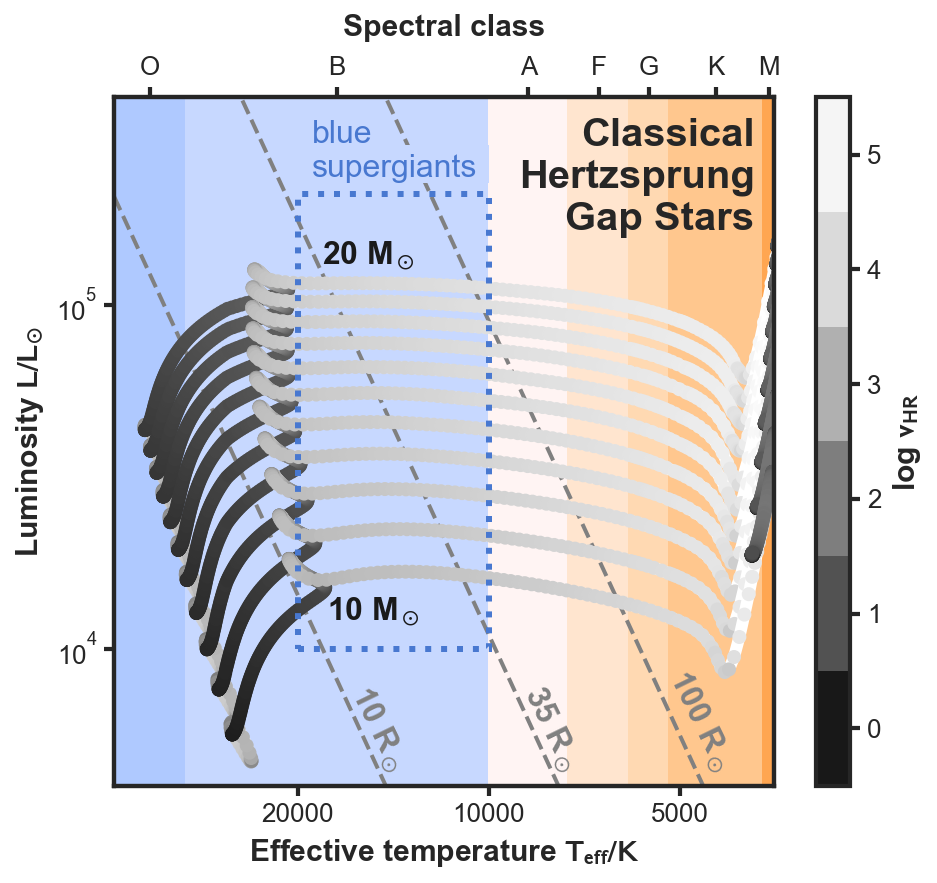

In [14]:
plot_tracks(grid, label='Classical\nHertzsprung\nGap Stars')

plt.text(np.log10(18000), 1.205*10**4, 
     r'10 M$_\odot$', c='k', size=16, weight='bold')
plt.text(np.log10(18300), 1.305*10**5, 
     r'20 M$_\odot$', c='k', size=16, weight='bold')

plt.savefig('figs/hr_normal.pdf')

Parsing {'M': 10.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830160>}
Parsing {'M': 11.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a148301c0>}
Parsing {'M': 12.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a148301f0>}
Parsing {'M': 13.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830220>}
Parsing {'M': 14.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830250>}
Parsing {'M': 15.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830280>}
Parsing {'M': 16.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a148302b0>}
Parsing {'M': 17.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a148302e0>}
Parsing {'M': 18.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830310>}
Parsing {'M': 19.0, 'os': 0.7, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a14830340>}
Parsing {'

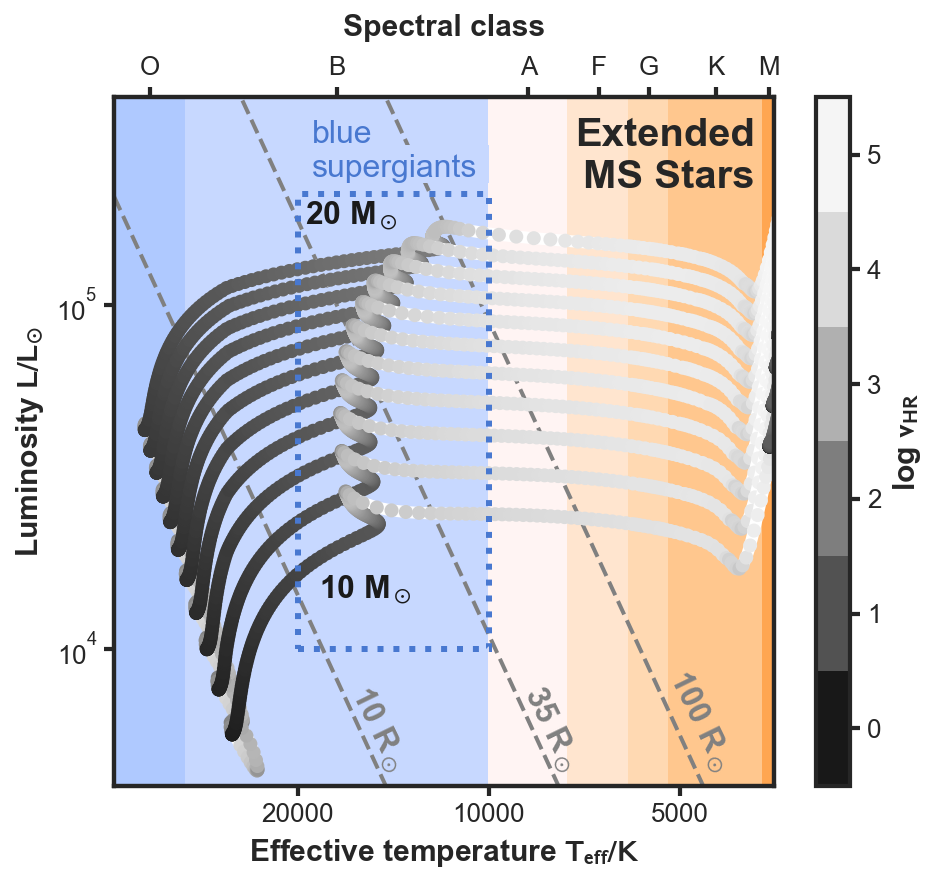

In [15]:
grid_os = grid_normal.filter({'os': 0.7, 'Z': 0.02})

plot_tracks(grid_os, label='Extended\nMS Stars')#, ylabel=' ') #label=r'$\alpha_{os}=0.6$')

plt.text(np.log10(18500), 1.405*10**4, 
     r'10 M$_\odot$', c='k', size=16, weight='bold')
plt.text(np.log10(19500), 1.705*10**5, 
     r'20 M$_\odot$', c='k', size=16, weight='bold')

#plt.gca().set_yticklabels([])
plt.savefig('figs/hr_Hcore.pdf')

100%|█████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 51848.91it/s]


Parsing {'M': 15.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a096a49a0>}
Parsing {'M': 10.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968a1c0>}
Parsing {'M': 11.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a303786a0>}
Parsing {'M': 12.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968a3a0>}
Parsing {'M': 13.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968a9d0>}
Parsing {'M': 14.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968a7f0>}
Parsing {'M': 16.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968a700>}
Parsing {'M': 17.0, 'mc': 0.3, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0968af10>}
Parsing {'M': 18.0, 'mc'

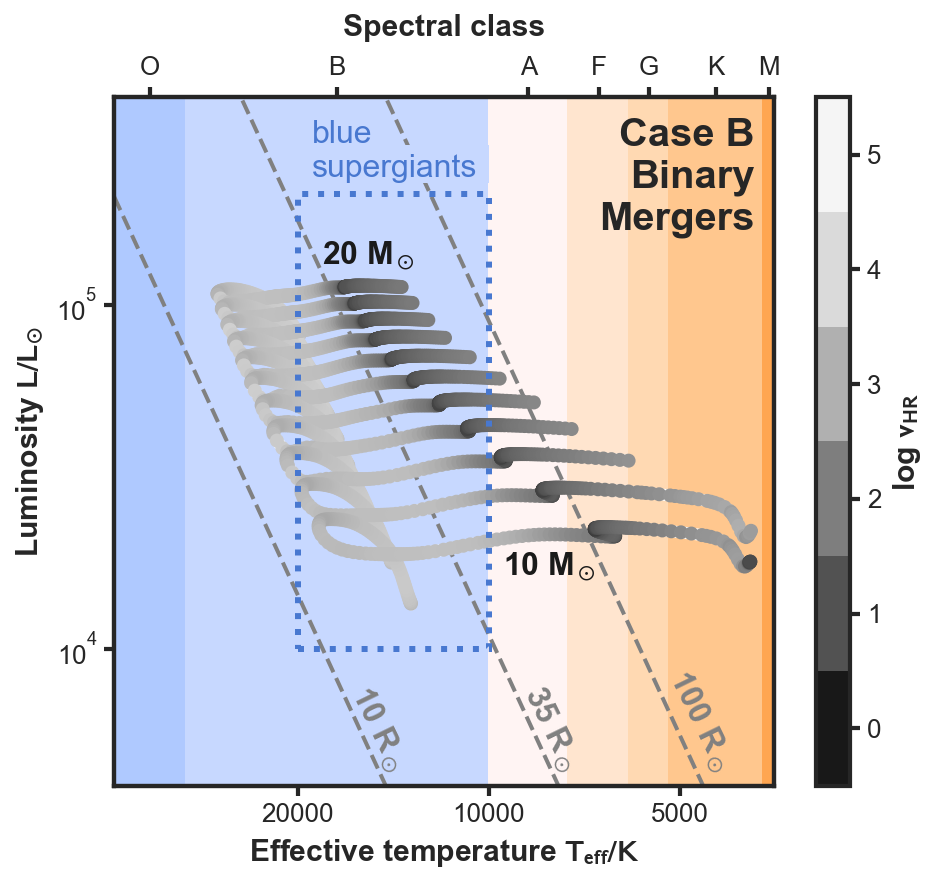

In [16]:
plot_tracks(grid_merger.filter({'mc': 0.3, 'mg': 0, 'Ye': 0.28, 'Z': 0.02}), 
            label='Case B\nBinary\nMergers')#, ylabel=' ')


plt.text(np.log10(9500), 1.630*10**4, 
     r'10 M$_\odot$', c='k', size=16, weight='bold')
plt.text(np.log10(18300), 1.305*10**5, 
     r'20 M$_\odot$', c='k', size=16, weight='bold')

#plt.gca().set_yticklabels([])
plt.savefig('figs/hr_merge.pdf')

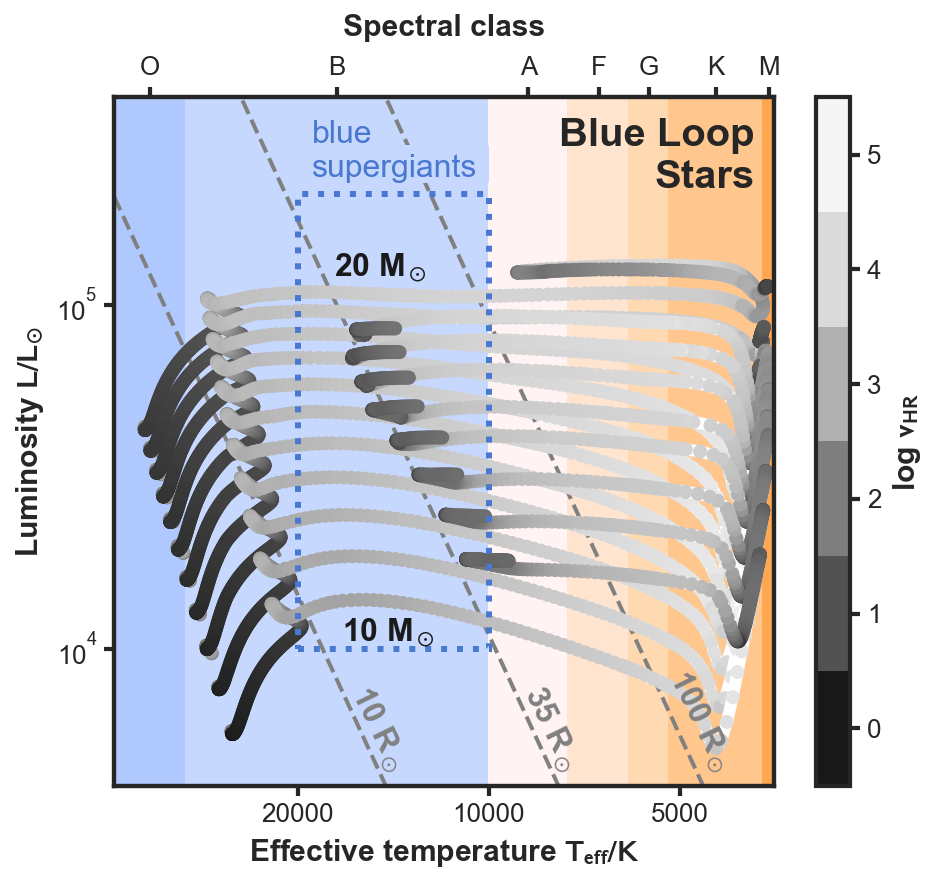

In [24]:
plot_tracks(grid_semi.filter({'os': 0.11}), 
            label='Blue Loop\nStars')#, ylabel=' ') 

plt.text(np.log10(17000), 1.05*10**4, 
     r'10 M$_\odot$', c='k', size=16, weight='bold')
plt.text(np.log10(17500), 1.205*10**5, 
     r'20 M$_\odot$', c='k', size=16, weight='bold')

#plt.gca().set_yticklabels(['', '']);
plt.savefig('figs/hr_blueloop.pdf')

In [18]:
grid_merge_hr = Grid('work/grid_merge_hr', 
                      load_history_extras=load_history_extras, usecols_history=usecols_history, cpus=cpus)
#grid_merge_hr.load()
#[row for row in grid_merge_hr.df.itertuples()]
for row in grid_merge_hr.df.itertuples():
    try:
        row.Track.history
    except FileNotFoundError:
        continue

grid_merge_hr#.df

100%|███████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 94846.07it/s]


Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a1c0>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.0, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a490>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.0, 'Ye': 0.42, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58ad90>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.15, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a2b0>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.15, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a460>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.15, 'Ye': 0.42, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a280>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.3, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58a5b0>}
Parsing {'M': 10.0, 'mc': 0.2, 'mg': 0.3, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b58ad30>}
Parsing {'M': 10.0, '

Parsing {'M': 15.0, 'mc': 0.35, 'mg': 0.3, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b560670>}
Parsing {'M': 15.0, 'mc': 0.35, 'mg': 0.3, 'Ye': 0.42, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b5603d0>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.0, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b5606a0>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.0, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b5606d0>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.0, 'Ye': 0.42, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b560700>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.15, 'Ye': 0.28, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b560730>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.15, 'Ye': 0.35, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b5604c0>}
Parsing {'M': 15.0, 'mc': 0.4, 'mg': 0.15, 'Ye': 0.42, 'Z': 0.02, 'Track': <mesagrid.star.Track object at 0x7f9a0b560760>}
Parsing {'M': 15.0,

Grid with 135 tracks
Columns: M, mc, mg, Ye, Z, Track
M              [10.0, 15.0, 20.0]
mc    [0.2, 0.25, 0.3, 0.35, 0.4]
mg               [0.0, 0.15, 0.3]
Ye             [0.28, 0.35, 0.42]
Z                          [0.02]
dtype: object

In [19]:
from ipywidgets.widgets import interact, SelectionSlider
from IPython.display import display

In [20]:
def interactive_plot(mc, mg, Ye, Z):
    tracks = grid_merge_hr.filter({'mc': mc, 'mg': mg, 'Ye': Ye, 'Z': Z})
    try:
        plot_tracks(tracks)
    except FileNotFoundError:
        next 
    plt.text(np.log10(11000), 1.630*10**4, r'10 M$_\odot$', c='k', size=16, weight='bold')
    plt.text(np.log10(18300), 1.305*10**5, r'20 M$_\odot$', c='k', size=16, weight='bold')
    plt.show();

mc_slider = SelectionSlider(options=sorted(grid_merge_hr.df['mc'].unique()), description='mc', value=0.3)
mg_slider = SelectionSlider(options=sorted(grid_merge_hr.df['mg'].unique()), description='mg')
Ye_slider = SelectionSlider(options=sorted(grid_merge_hr.df['Ye'].unique()), description='Ye')
Z_slider = SelectionSlider(options=sorted(grid_merge_hr.df['Z'].unique()), description='Z', value=0.02)

interact(interactive_plot, mc=mc_slider, mg=mg_slider, Ye=Ye_slider, Z=Z_slider);

interactive(children=(SelectionSlider(description='mc', index=2, options=(0.2, 0.25, 0.3, 0.35, 0.4), value=0.…